# Lab Two: Classification
##### Laura Ahumada, Shikha Pandey, Kevin Boyd, Duy Nguyen

### Libraries

In [179]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import metrics as mt
import matplotlib.pyplot as plt
from sklearn.svm import SVC

### Import Data

In [180]:
df = pd.read_csv('adult.csv')

In [181]:
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


# Data Preparation: Part 1
- ##### Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [182]:
df.isnull().values.any()

False

In [183]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [184]:
cat_cols = df.select_dtypes(exclude=['int64','int32'])
for i in cat_cols:
    print(cat_cols[i].value_counts().sort_index().index)

Index(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
       'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
      dtype='object')
Index(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
       'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
       'Masters', 'Preschool', 'Prof-school', 'Some-college'],
      dtype='object')
Index(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
       'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
      dtype='object')
Index(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
       'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
       'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
       'Sales', 'Tech-support', 'Transport-moving'],
      dtype='object')
Index(['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
       'Wife'],
      dtype='object')
Index(['Amer-Indian-Eskimo', 'Asian

### Things to address:
- ##### Incorrect values "?" values
- ##### Decrease categories in native.countries to immigrants or not (1 or 0)
- ##### Deleting education since it is the same information as education.num
- ##### Encode response variable "income" to 1 or 0
- ##### Encode all categorical variables to 1 or 0, rather than ranked numbers

Despite the "?" values taking around 5% of their respective columns "workclass", "occupation", "native.country", they will not be removed due since it might be due to citizens not wanting to report those 3 things to the government. However, their incomes were still reported among other factors so the missing values will be treated another category "Unknown"

In [185]:
df.isin(['?']).sum(axis=0) * 100 / len(df)

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

In [186]:
df = df.replace({'?':'Unknown'})

In [187]:
df.isin(['?']).sum(axis=0) * 100 / len(df)

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education.num     0.0
marital.status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital.gain      0.0
capital.loss      0.0
hours.per.week    0.0
native.country    0.0
income            0.0
dtype: float64

- ##### "Native Country": Replace Non-US with "Immigrant"

In [188]:
# Changing Native Country since the rest of US by country is small that they could all be combined to single to have a greater weight
df['IsImmigrant'] = np.where(df['native.country']!= 'United-States', 1, 0)
del df['native.country']

In [189]:
df.IsImmigrant.value_counts(normalize=True) * 100

0    89.585701
1    10.414299
Name: IsImmigrant, dtype: float64

In [190]:
# Deleting education
del df['education']

- ##### "Income": As 1 and 0 

In [191]:
# Checing the target variable distribution
df.income.value_counts(normalize=True) * 100

<=50K    75.919044
>50K     24.080956
Name: income, dtype: float64

In [192]:
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int) 

In [193]:
df.income.value_counts(normalize=True) * 100

0    75.919044
1    24.080956
Name: income, dtype: float64

- ##### Encoding Categorical Variables 

In [194]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
income             int64
IsImmigrant        int64
dtype: object

In [195]:
df_continuous = df.select_dtypes(exclude=['object'])
df_discrete = df.select_dtypes(exclude=['int64','int32'])

In [196]:
df_continuous.columns

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week', 'income', 'IsImmigrant'],
      dtype='object')

In [197]:
df_discrete.columns

Index(['workclass', 'marital.status', 'occupation', 'relationship', 'race',
       'sex'],
      dtype='object')

In [198]:
df=pd.get_dummies(creditData, columns=df_discrete.columns)

In [200]:
df.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,IsImmigrant,workclass_Federal-gov,workclass_Local-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,90,77053,9,0,4356,40,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,82,132870,9,0,4356,18,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,66,186061,10,0,4356,40,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,54,140359,4,0,3900,40,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
4,41,264663,10,0,3900,40,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


- ##### Separate Features from Response (Prep for Models)

In [77]:
x = df.drop("income", axis = 1)

In [97]:
y = df["income"] # this returns a dataframe, better suited for model functions
                   # rather than df["income"]

- ##### Scaling the Data

In [79]:
scaled_x = StandardScaler().fit_transform(x)
scaled_x

array([[ 3.76961234, -1.06799736, -0.42005962, ...,  0.4130197 ,
         1.42233076, -1.42233076],
       [ 3.18311167, -0.53916866, -0.42005962, ...,  0.4130197 ,
         1.42233076, -1.42233076],
       [ 2.01011032, -0.03521956, -0.03136003, ..., -2.421192  ,
         1.42233076, -1.42233076],
       ...,
       [ 0.10398314, -0.33543266, -0.42005962, ...,  0.4130197 ,
        -0.70307135,  0.70307135],
       [ 1.42360965, -0.35877741, -0.42005962, ...,  0.4130197 ,
         1.42233076, -1.42233076],
       [-1.21564337,  0.11095988, -0.42005962, ...,  0.4130197 ,
        -0.70307135,  0.70307135]])

### Dimension Reduction with PCA
- ##### Kaiser Rule: the goal is to seek number of PCs that have eigenvalues >= 1, hence the dotted red line below

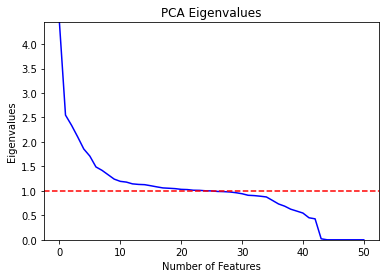

25 feature(s) are enough to describe the data.


In [80]:
pca = PCA(n_components=None) # initially set n_components to "None" to include all 67 features
pca.fit(scaled_x)

plt.ylabel('Eigenvalues')
plt.xlabel('Number of Features')
plt.title('PCA Eigenvalues')
plt.ylim(0, max(pca.explained_variance_))
plt.plot(pca.explained_variance_, color='b')
plt.axhline(y=1, color='r', linestyle='--')
plt.show()

# display the actual eigenvalues
count = 0
for i in pca.explained_variance_ :
    if i > 1 :                       # eigenvalues >= 1
        count = count + 1
print(count, 'feature(s) are enough to describe the data.')

- ##### Cumulative Variance Explained: the selected PCs should describe atleast 80% of the data, hence the dotted red line below

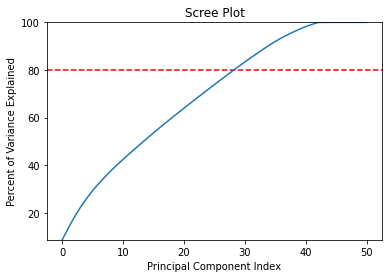

22 principal components(s) describe atleast 80% of the data.


In [81]:
variance = pca.explained_variance_ratio_ * 100
cumu_variance = np.cumsum(variance)

plt.ylabel('Percent of Variance Explained')
plt.xlabel('Principal Component Index')
plt.title('Scree Plot')
plt.ylim(min(cumu_variance), 100)
plt.axhline(y=80, color='r', linestyle='--')
plt.plot(cumu_variance)
plt.show()

cumu_variance
# display the actual eigenvalues
count = 0
for i in cumu_variance :
    if i > 80 :                       # eigenvalues >= 1
        count = count + 1
print(count, 'principal components(s) describe atleast 80% of the data.')

# Data Preparation: Part 2
- ##### Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

-- LA added this piece  --

The data consists of 32,561 entries/rows and 13 attributes/columns, with the response variable being "income"

Out of the 13 variables, 6 are continuous and 7 are categories. The only new variable that was created is "IsImmigrant" which was set because of the discrepancy between US as native.country and the rest of the countries having such tiny percentage. We thought have is immigrant could explain better/have a larger representation due to the results of the data. In exchange we dropped native.country was the new attribute was created. 

Per EDA this data is not suited well for PCA.

Continuous variables: age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week, IsImmigrant

Categorical Variables: Workclass,marital.status, occupation, relationship, race, sex, 


In order to begin prep for the models the continuous attributes have been standarized and the categorical variables have been converted into one hot encoding.

Our goal with this final dataset is to classify whether if people have greater than $50k income or not, which includes 1 response variable and 67 predictor variables. Out of those 67, 6 are unchanged as they are originally continuous, 1 was originally "native.country" which was modify to "IsImmigrant" (with "United States" as "0" and others as "1"), and the rest 60 are one-hot encoded as dummies.

PCA is not an appropriate pre-processing method for our data, since we have too many PCs that efficiently describes our data.

# Modeling and Evaluation: Part 1
- ##### Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.


--LA added this piece--

Out of Precision, Accuracy and Recall, the most useful for our task is Precision. That will be one of the metricts will focuse on. Precision will be able to focuse on the target >50K and state out of all of all the >50k how many it was able to predict correctly. That is the main goal of the task  is to be able to predict correctly those people that will obtain >50k. From that data we can further analyse which are these important factors and from there see if there is any sociatal gaps that need to be look at etc.

However, we will also have to take into account the fact 75% are stated to have <= 50K and only 25% are earning >50K. Because of that we will need modify the threashold to adjust the measurments. 50% threashold wouldn't represent the data correctly.

ROC will also be used to compare the models and its results.

Accuracy is a good metric to use because it determines the performance of many models. 

Precision and recall should become useful for clients that desire a specific outcome from our results. 

An example can be an expensive form of financial aid that is being planned for people that are true negatives (predicted to NOT make more than 50K and actually makes less than 50K), where we want a classification threshold to both balance a highly accurate true positive and a highly accurate true negative, so that the client is not wasting money on applying that relief to people that are false positive or false negative. The same can be said to a dataset that is created to predict cancer, where we want a high number of people who actually have cancer and people who actually don't have cancer, so that people can correctly have their cancer-curing procedure and would not have wasted time and money on one.

A reversed example would be a new product being more favorable towards higher income people, where we can sacrifice the fact that a very high and innaccurate number of true positives is still permissible, because a phone call to people who are false positive, or rather people that are predicted to have greater than $50k income who actually aren't, does not have the same impact as a cancer-curing procedure.

# Modeling and Evaluation: Part 2
- ##### Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. 

We will be using Stratified 10 fold cross validation because we want to be able to split the variables equally among the testing and trainig data. For instance if don't use stratified the train data may obtain only 5 percent of the data with >50K which then ends up leading to a model that is not able to predict as well since it has so little information on those with >50K. We want the distribtuion of those with >50K and as well as those with <=50K to be equally representative in trainting and testing. As for cross validation we thought it was the most appropriate because it is able to pick different records and then give us an estimate on what the precision really is.

- ##### Splitting the Data

In [103]:
# x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, stratify=y, test_size = .2, random_state=1)
# # 80% train, 20% test
# # seed = 1

Create three different classification/regression models (e.g., random forest, 
KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or 
logistic regression). Adjust parameters as appropriate to increase generalization 
performance using your chosen metric. 

# Logistic Regression

In [306]:
def score_rep (y_test, y_hat):
    acc = mt.accuracy_score(y_test,y_hat)
    rec = mt.recall_score(y_test,y_hat)
    prec = mt.precision_score(y_test,y_hat)
    f1= mt.f1_score(y_test,y_hat)
    auc=mt.roc_auc_score(y_test,y_hat)
    print('Accuracy is: %.2f, Recall is: %.2f, Precision is: %.2f, F1 is %.2f and AUC is %.2f'% (acc,rec,prec,f1,auc))
    return(acc, rec,prec,f1,auc)

In [ ]:
# X_train_scaled = scl_obj.transform(X_train) # apply to training
# X_test_scaled = scl_obj.transform(X_test)

In [307]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

model_name=[]
model_results=[]
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' )

# Creating Training and Testing split
num_cv_iterations =3

cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
acc_list=[]
rec_list=[]
prec_list=[]
for train_indices, test_indices in cv_object.split(scaled_x,y.values): 

    X_train_scaled=scaled_x[train_indices]
    y_train = y[train_indices]
    X_test_scaled=scaled_x[test_indices]
    y_test = y[test_indices]
    
lr=lr_clf.fit(X_train_scaled,y_train)
y_hat=lr.predict(X_test_scaled)
acc, rec,prec,f1,auc=score_rep(y_test,y_hat)
        
model_result=[[acc, rec,prec,f1,auc]]
model_name.append("Logistic Regression")

Accuracy is: 0.85, Recall is: 0.62, Precision is: 0.72, F1 is 0.66 and AUC is 0.77


- # Interpreting Weights


##### The most important variables per Logistic regression 
    Capital gain 
    Education num
    Marital status 
    Age
    Hours per Week

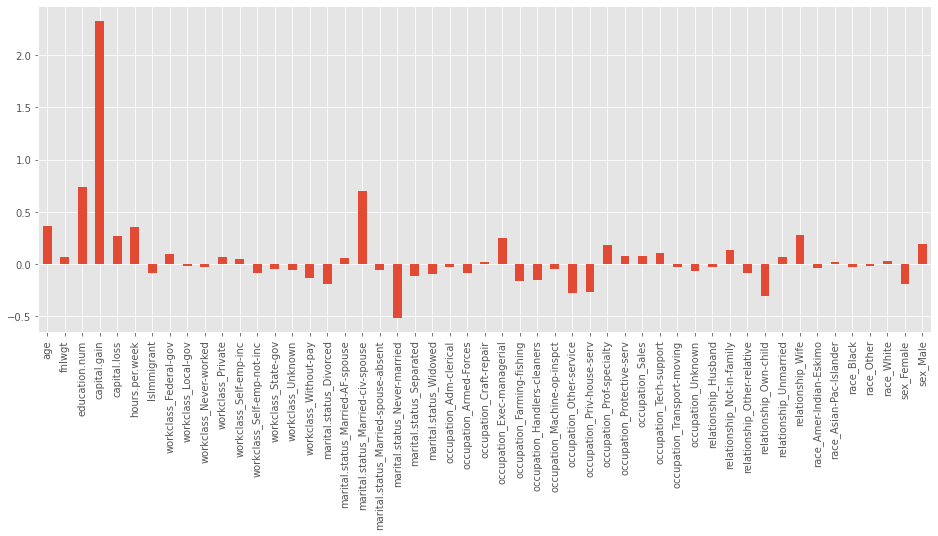

In [136]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,6))
plt.style.use('ggplot')


weights = pd.Series(lr.coef_[0],index=x.columns)
weights.plot(kind='bar')
plt.show()

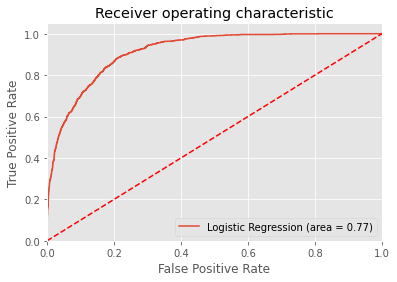

In [280]:
#AUC ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test_scaled))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# SVM

In [288]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set predictions

# Get all scores
acc, rec,prec,f1,auc=score_rep(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print(conf)
# Append to list of all scores
model_results.append([acc, rec,prec,f1,auc])
model_name.append("SVM")

Accuracy is: 0.85, Recall is: 0.60, Precision is: 0.75
[[4636  312]
 [ 633  932]]


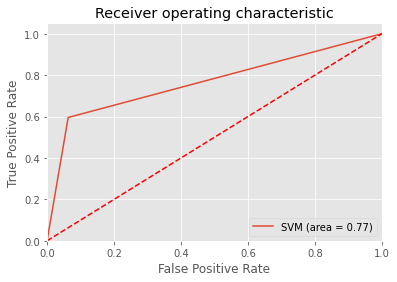

In [297]:
# auc=metrics.roc_auc_score(y_test, y_hat)

fpr, tpr, thresholds = roc_curve(y_test, y_hat)
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
                      

# Decision Tree

In [309]:
# Standarizing variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
minmax_scale = MinMaxScaler()

for i in (df_continuous.columns):
    if i !="income":
        x[i] = minmax_scale.fit_transform(x[[i]])

In [310]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y,test_size=.30, random_state=1)

In [215]:
from sklearn.tree import DecisionTreeClassifier
dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state=1)
dTreeR=dTreeR.fit(X_train, y_train)
y_hat=dTreeR.predict(X_test)
# run function to get accuracy, recall and precision
acc,rec,prec=score_rep(y_test,y_hat)
# Append to list of results
model_results.append([acc,rec,prec])
model_name.append("Decision Classifier")

conf = mt.confusion_matrix(y_test,y_hat)
print(conf)

print("Training score",dTreeR.score(X_train, y_train))
print("Testing score",dTreeR.score(X_test, y_test))


0.8419620919620919
0.8483979936533934


+ Let's visualize it

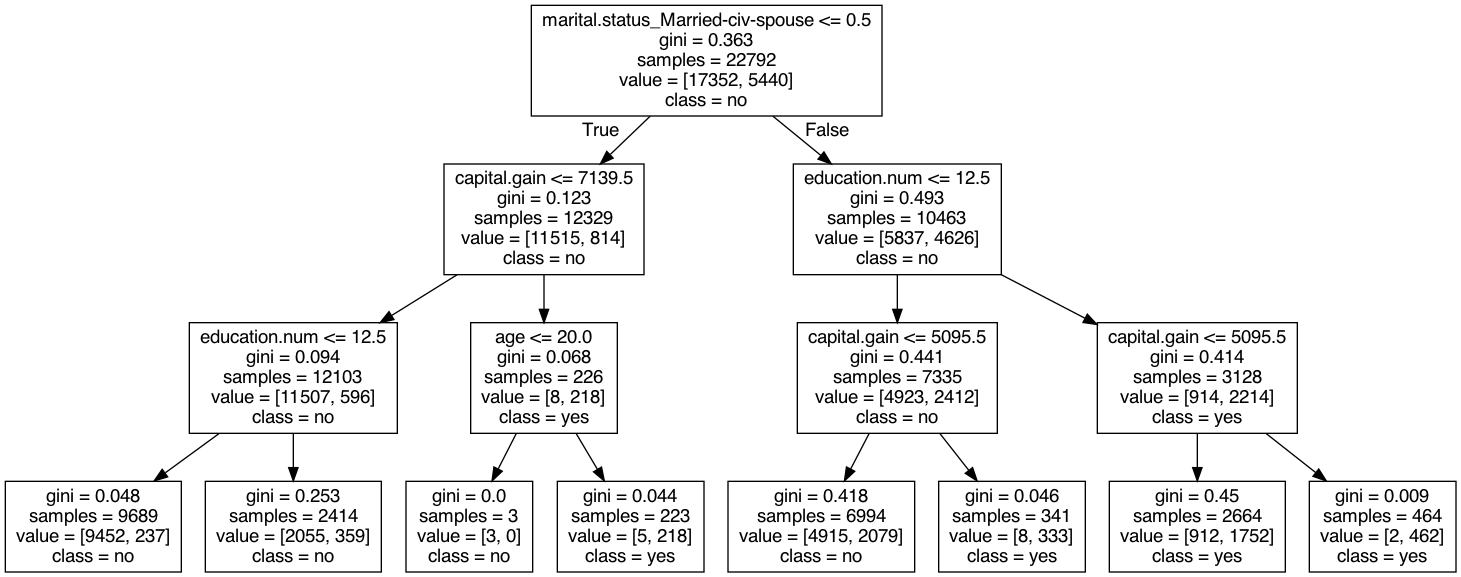

In [208]:
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system
train_char_label = ["no", "yes"]
Credit_Tree_FileR = open('credit_treeR.dot','w')
dot_data = tree.export_graphviz(dTreeR, out_file=Credit_Tree_FileR, feature_names = list(X_train), class_names = list(train_char_label))
Credit_Tree_FileR.close()

retCode = system("dot -Tpng credit_treeR.dot -o credit_treeR.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("credit_treeR.png"))



+ For decision tree we can see that it picked up Married CIV spouse as the most important followed by capital.gain and education.num. We do know that decision trees are affected by what it sees first therefore we will do Random forest next

# Ensemble RandomForest Classifier

In [311]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1,max_features=12)
rfcl = rfcl.fit(X_train, y_train)
y_predict = rfcl.predict(X_test)
#Get all scores
acc, rec,prec,f1,auc=score_rep(y_test,y_predict)
# Append to list of scores
model_results.append([acc, rec,prec,f1,auc])
model_name.append("Random Forest")

Accuracy is: 0.86, Recall is: 0.63, Precision is: 0.75, F1 is 0.69 and AUC is 0.78


In [312]:
 rfcl.predict_proba(X_test)[:,1]

array([0.24, 0.64, 0.14, ..., 0.  , 0.  , 0.  ])

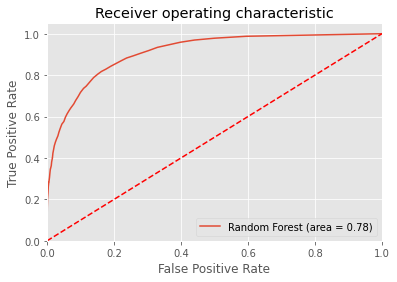

In [313]:

fpr, tpr, thresholds = roc_curve(y_test, rfcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

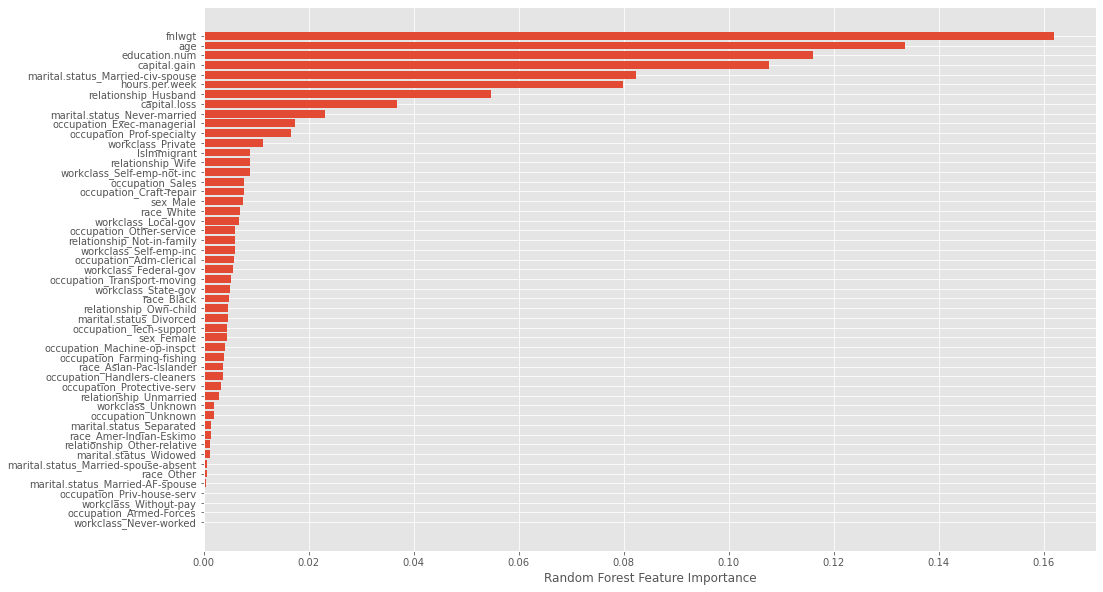

In [325]:
sorted_idx = rfcl.feature_importances_.argsort()
plt.figure(figsize=(16,10))
plt.barh(x.columns[sorted_idx], rfcl.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Naybe Bayes Classifier


In [248]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# Running model with different parameters

alpha_list=[0.1,0.5,0.7,1.0,5]
binarize_list=[0.0,0.05,0.07,0.09,2]
multi_result=[]
bernou_result=[]

for i in (alpha_list):
    clf_mnb = MultinomialNB(alpha=i)
    multi_model=clf_mnb.fit(X_train, y_train)
    multi_hat=multi_model.predict(X_test)
    acc = mt.recall_score(y_test,multi_hat)
    multi_result.append(acc)
    for j in (binarize_list):
        clf_bnb = BernoulliNB(alpha=i, binarize=j)
        bern=clf_bnb.fit(X_train, y_train)
        y_hat=bern.predict(X_test)
        acc = mt.recall_score(y_test,y_hat)
        bernou_result.append(acc)
        
print("The best Bernoulli recall was %.2f, while the best Multinomial recall was %.2f"%(max(bernou_result), max(multi_result)))


The best Bernoulli recall was 0.83, while the best Multinomial recall was 0.77


In [252]:
# Best naive bayes model was bernoulli
clf_bnb = BernoulliNB(alpha=0.5, binarize=0.07)
bern=clf_bnb.fit(X_train, y_train)
y_hat=bern.predict(X_test)
acc, rec,prec,f1,auc=score_rep(y_test,y_hat)
model_results.append([acc, rec,prec,f1,auc])
model_name.append("NaiveBayes Bernoulli")

Accuracy is: 0.75, Recall is: 0.83, Precision is: 0.49


# KNN

In [264]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from IPython.html import widgets 

print("Metric Cosine")
# fill in your code  here to train and test
# calculate the accuracy and print it for various values of K
for i in ([5,13,16,18,25]):
    clf = KNeighborsClassifier(n_neighbors=i, weights='uniform', metric='cosine')
    clf=clf.fit(X_train, y_train)
    y_hat=clf.predict(X_test)
    print("With %d neighbors"% (i))
    acc, rec,prec,f1,auc=score_rep(y_test,y_hat)

With 1 neighbors
Accuracy is: 0.80, Recall is: 0.57, Precision is: 0.59
With 5 neighbors
Accuracy is: 0.83, Recall is: 0.58, Precision is: 0.67
With 13 neighbors
Accuracy is: 0.83, Recall is: 0.59, Precision is: 0.69
With 16 neighbors
Accuracy is: 0.84, Recall is: 0.55, Precision is: 0.73
With 25 neighbors
Accuracy is: 0.84, Recall is: 0.59, Precision is: 0.71


In [266]:
# fill in your code  here to train and test
# calculate the accuracy and print it for various values of K
print("Metric euclidean")
for i in ([5,16,18,25]):
    clf = KNeighborsClassifier(n_neighbors=i, weights='uniform', metric='euclidean')
    clf=clf.fit(X_train, y_train)
    y_hat=clf.predict(X_test)
    print("With %d neighbors"%(i))
    acc, rec,prec,f1,auc=score_rep(y_test,y_hat)

With 16 neighbors
Accuracy is: 0.84, Recall is: 0.54, Precision is: 0.73
With 18 neighbors
Accuracy is: 0.84, Recall is: 0.55, Precision is: 0.74
With 25 neighbors
Accuracy is: 0.84, Recall is: 0.57, Precision is: 0.72


In [268]:
# fill in your code  here to train and test
# calculate the accuracy and print it for various values of K
print("Metric Manhattan")
for i in ([5,13,16,18,25]):
    clf = KNeighborsClassifier(n_neighbors=i, weights='uniform', metric='manhattan')
    clf=clf.fit(X_train, y_train)
    y_hat=clf.predict(X_test)
    print("With %d neighbors"%(i))
    acc, rec,prec,f1,auc=score_rep(y_test,y_hat)

Metric Manhattan
With 5 neighbors
Accuracy is: 0.83, Recall is: 0.57, Precision is: 0.68
With 13 neighbors
Accuracy is: 0.84, Recall is: 0.58, Precision is: 0.72
With 16 neighbors
Accuracy is: 0.84, Recall is: 0.54, Precision is: 0.74
With 18 neighbors
Accuracy is: 0.84, Recall is: 0.54, Precision is: 0.73
With 25 neighbors
Accuracy is: 0.84, Recall is: 0.57, Precision is: 0.72


In [326]:
# 13 neighbors and Manhattan was the best one between precision and recall
clf = KNeighborsClassifier(n_neighbors=16, weights='uniform', metric='manhattan')
clf=clf.fit(X_train, y_train)
y_hat=clf.predict(X_test)
acc, rec,prec,f1,auc=score_rep(y_test,y_hat)
model_results.append([acc, rec,prec,f1,auc])

Accuracy is: 0.83, Recall is: 0.55, Precision is: 0.69, F1 is 0.61 and AUC is 0.73


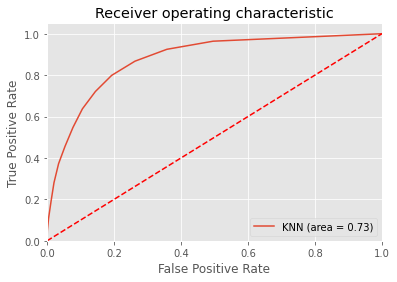

In [327]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Since grid search was taking too long I did the above trying different k and metrics..
This should run fine it just never stops running can you all tell me if the bellow runs for you all?

In [ ]:
## Grid search

In [225]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [228]:
#from tqdm import tqdm

In [269]:

### Number of nearest neighbors grid search
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

param_grid = {'n_neighbors': list(range(1,16,3)),
             'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(knn_clf,param_grid,cv=10)
gs.fit(X_train, y_train)
gs.best_params_

gs.cv_results_['params']

KeyboardInterrupt: 

In [236]:
# random forest grid search
from scipy.stats import randint as sp_randint
rf_clf = RandomForestClassifier(n_estimators=50)

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
# # use a full grid over all parameters
# param_grid = {"max_depth": [3, None],
#               "max_features": [1, 3, 10 ],
#               "min_samples_split": [2, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(rf_clf, param_grid=param_grid)

grid_search.fit(X_train, y_train)

# grid_search.best_params_

# grid_search.cv_results_['mean_test_score']

# grid_search.best_estimator_

KeyboardInterrupt: 

0.8618077592384072


<AxesSubplot:>

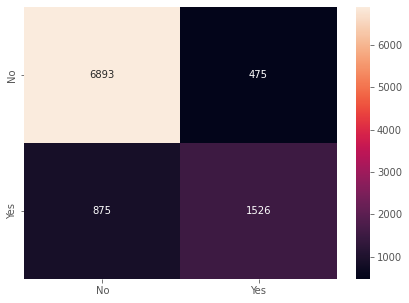

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1,max_features=12)
rfcl = rfcl.fit(X_train, y_train)
y_predict = rfcl.predict(X_test)
# print(rfcl.score(X_test, y_test))
# cm=metrics.confusion_matrix(y_test, y_predict,labels=[0, 1])

# df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
#                   columns = [i for i in ["No","Yes"]])
# plt.figure(figsize = (7,5))
# sns.heatmap(df_cm, annot=True ,fmt='g')